In [17]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings
warnings. simplefilter(action='ignore', category=Warning)

THE ABOVE CODE IMPORTS ALL THE REQUIRED LIBRARIES.

NOW WE NEED TO FETCH THE HISTORICAL STOCK DATA USING YAHOO FINANCE USING THE CODE BELOW.

In [ ]:
#DATA COLLECTION
equity_details = pd.read_csv('EQUITY_L.csv')
for name in equity_details.SYMBOL:
    try:
        data = yf.download(f'{name}.NS')
        data.to_csv(f'../2)data/{name}.csv')
    except Exception as e:
        print(f'{name} ---> {e}')

Now we write a code for GOLDEN CROSSOVER. It occurs when a short-term moving average, typically a 50-day moving average, crosses above a longer-term moving average, often the 200-day moving average, for a particular stock or market index. 

In [19]:
#GOLDEN CROSSOVER
def GoldenCrossverSignal(name, data_point):
    path = f'../2)data/{name}.csv'
    data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
    data['50_DMA'] = data.Close.rolling(window=50, min_periods=1).mean()
    data['200_DMA'] = data.Close.rolling(window=200, min_periods=1).mean()
    data['Signal'] = 0
    data['Signal'] = np.where(data['50_DMA'] > data['200_DMA'], 1, 0)
    data['Position'] = data.Signal.diff()
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data.iloc[-data_point:]['Close'].plot(color = 'k', label= 'Close Price') 
    data.iloc[-data_point:]['50_DMA'].plot(color = 'b',label = '50-day DMA') 
    data.iloc[-data_point:]['200_DMA'].plot(color = 'g', label = '200-day DMA')
    # plot ‘buy’ signals
    plt.plot(data.iloc[-data_point:][data.iloc[-data_point:]['Position'] == 1].index, 
             data.iloc[-data_point:]['50_DMA'][data.iloc[-data_point:]['Position'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data.iloc[-data_point:][data.iloc[-data_point:]['Position'] == -1].index, 
             data.iloc[-data_point:]['50_DMA'][data.iloc[-data_point:]['Position'] == -1], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('Price in Rupees', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title(name, fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()
    df_pos = data.iloc[-data_point:][(data.iloc[-data_point:]['Position'] == 1) | (data['Position'] == -1)].copy()
    df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
    print(tabulate(df_pos[['Close', 'Position']], headers = 'keys', tablefmt = 'psql'))

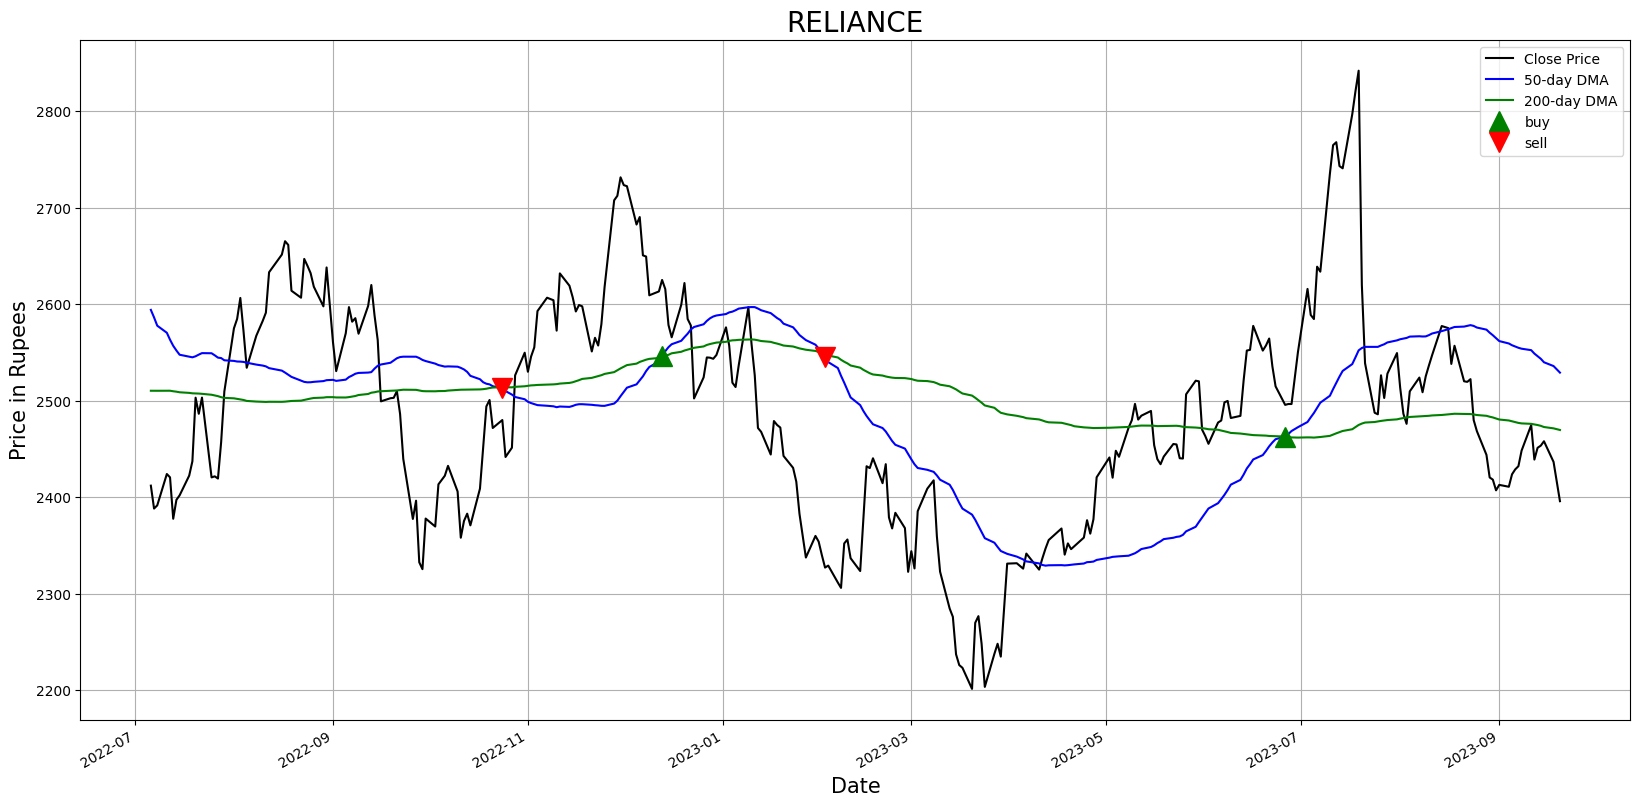

+---------------------+---------+------------+
| Date                |   Close | Position   |
|---------------------+---------+------------|
| 2022-10-24 00:00:00 | 2479.85 | Sell       |
| 2022-12-13 00:00:00 | 2625    | Buy        |
| 2023-02-02 00:00:00 | 2326.95 | Sell       |
| 2023-06-26 00:00:00 | 2495.55 | Buy        |
+---------------------+---------+------------+


In [20]:
GoldenCrossverSignal('RELIANCE',300)

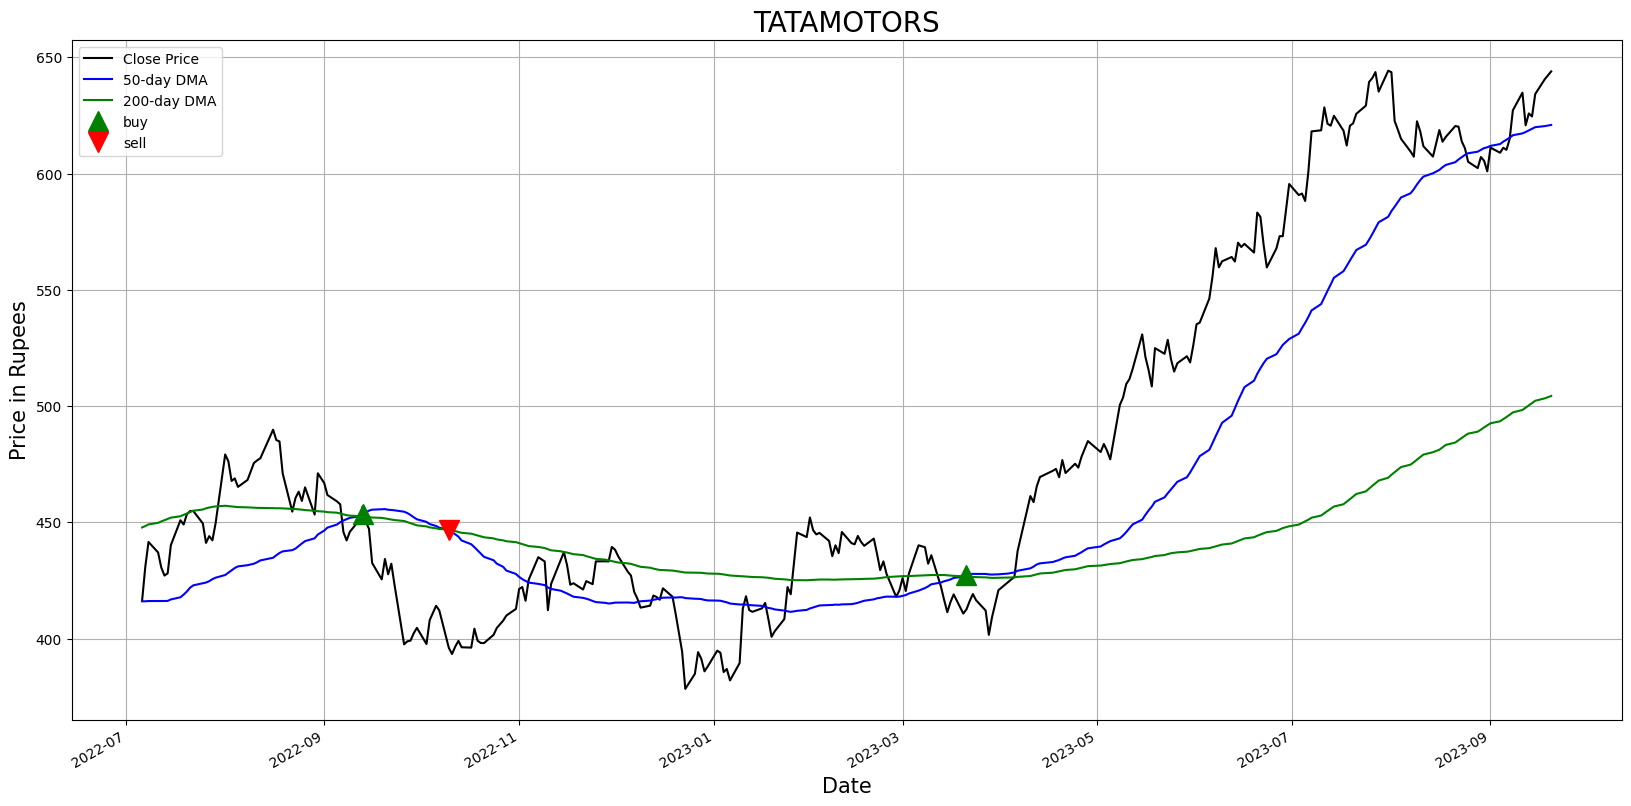

+---------------------+---------+------------+
| Date                |   Close | Position   |
|---------------------+---------+------------|
| 2022-09-13 00:00:00 |  456.8  | Buy        |
| 2022-10-10 00:00:00 |  395.95 | Sell       |
| 2023-03-21 00:00:00 |  412.55 | Buy        |
+---------------------+---------+------------+


In [21]:
GoldenCrossverSignal('TATAMOTORS',300)

Now, we need to backtest the strategies that we have coded. We apply the GOLDEN CROSSOVER indicator on the stocks and see how it performs.

In [22]:
#BACKTESTING CODE
def GoldenCrossverSignal(name):
    path = f'../2)data/{name}.csv'
    data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
    data['Prev_Close'] = data.Close.shift(1) #we use prev_close to remove forwad bias
    data['50_DMA'] = data.Prev_Close.rolling(window=50, min_periods=1).mean()
    data['200_DMA'] = data.Prev_Close.rolling(window=200, min_periods=1).mean()
    data['Signal'] = 0
    data['Signal'] = np.where(data['50_DMA'] > data['200_DMA'], 1, 0)
    data['Position'] = data.Signal.diff()
    df_pos = data[(data['Position'] == 1) | (data['Position'] == -1)].copy()
    df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
    return df_pos
data = GoldenCrossverSignal('RELIANCE')
req_data = data[(data.index >= data[data['Position'] == 'Buy'].index[0]) & (data.index <= data[data['Position'] == 'Sell'].index[-1])]

# Name, Entry TIme, Entry PRice, QTY, Exit Time, Exit Price
class Backtest:
    def __init__(self):
        self.columns = ['Equity Name', 'Trade', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Quantity', 'Position Size', 'PNL', '% PNL']
        self.backtesting = pd.DataFrame(columns=self.columns)

    def buy(self, equity_name, entry_time, entry_price, qty):
        self.trade_log = dict(zip(self.columns, [None] * len(self.columns)))
        self.trade_log['Trade'] = 'Long Open'
        self.trade_log['Quantity'] = qty
        self.trade_log['Position Size'] = round(self.trade_log['Quantity'] * entry_price, 3)
        self.trade_log['Equity Name'] = equity_name
        self.trade_log['Entry Time'] = entry_time
        self.trade_log['Entry Price'] = round(entry_price, 2)

    def sell(self, exit_time, exit_price, exit_type, charge):
        self.trade_log['Trade'] = 'Long Closed'
        self.trade_log['Exit Time'] = exit_time
        self.trade_log['Exit Price'] = round(exit_price, 2)
        self.trade_log['Exit Type'] = exit_type
        self.trade_log['PNL'] = round((self.trade_log['Exit Price'] - self.trade_log['Entry Price']) * self.trade_log['Quantity'] - charge, 3)
        self.trade_log['% PNL'] = round((self.trade_log['PNL'] / self.trade_log['Position Size']) * 100, 3)
        self.trade_log['Holding Period'] = exit_time - self.trade_log['Entry Time']
        new = pd.DataFrame([self.trade_log])
        self.backtesting = pd.concat([new,self.backtesting], ignore_index=True)
bt = Backtest()
capital = 20000 #We take initial capital of ₹20,000
for index, data in req_data.iterrows():
    if(data.Position == 'Buy'):
        qty = capital // data.Open
        bt.buy('RELIANCE', index, data.Open, qty)
    else:
        bt.sell(index, data.Open, 'Exit Trigger', 0)


Now we will run our backtesting algorithm which will generate the BUY & SELL signals.

In [23]:
bt.backtesting

,Equity Name,Trade,Entry Time,Entry Price,Exit Time,Exit Price,Quantity,Position Size,PNL,% PNL,Exit Type,Holding Period
0,RELIANCE,Long Closed,2022-12-14,2637.65,2023-02-03,2349.00,7.0,18463.549,-2020.55,-10.943,Exit Trigger,51 days
1,RELIANCE,Long Closed,2021-06-28,2122.00,2022-10-25,2499.00,9.0,19098.000,3393.00,17.766,Exit Trigger,484 days
2,RELIANCE,Long Closed,2020-06-15,1565.00,2021-04-08,2011.00,12.0,18780.000,5352.00,28.498,Exit Trigger,297 days
3,RELIANCE,Long Closed,2019-10-25,1427.57,2020-03-25,954.75,14.0,19985.954,-6619.48,-33.121,Exit Trigger,152 days
4,RELIANCE,Long Closed,2016-08-08,505.16,2019-09-06,1191.70,39.0,19701.301,26775.06,135.905,Exit Trigger,1124 days
5,RELIANCE,Long Closed,2015-11-30,484.66,2016-07-07,491.59,41.0,19870.894,284.13,1.430,Exit Trigger,220 days
6,RELIANCE,Long Closed,2015-07-07,500.75,2015-10-09,442.83,39.0,19529.381,-2258.88,-11.567,Exit Trigger,94 days
7,RELIANCE,Long Closed,2014-04-17,468.06,2014-12-01,489.86,42.0,19658.656,915.60,4.657,Exit Trigger,228 days
8,RELIANCE,Long Closed,2013-07-18,454.69,2014-02-21,399.76,43.0,19551.670,-2361.99,-12.081,Exit Trigger,218 days
9,RELIANCE,Long Closed,2012-09-07,385.69,2013-05-06,397.33,51.0,19670.394,593.64,3.018,Exit Trigger,241 days


Using sum() function we will add our profits and subtract our losses and see how much we have made in Ruppees.

In [24]:
bt.backtesting.to_csv('RELIANCE_TEST.csv')
bt.backtesting.PNL.sum()

186446.42999999996

As we can see that our investment of 20,000 Ruppees in 1990's would have become 1,86,446.43 Ruppees by now if we would have used the GOLDEN CROSSOVER ALGORITHM. Hence, a profit of 930%.